In [1]:
cd drive/MyDrive/chicks

/content/drive/MyDrive/chicks


In [2]:
ls

ChickenFronts/  ChickenMasks/  simple_unet_model.py


In [3]:
from simple_unet_model import multi_unet_model

In [10]:
from tensorflow.keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt

Define number of classes and Input sizes

In [11]:
SIZE_X = 512
SIZE_Y = 512
n_classes = 6

Data reading and preprocessing

In [18]:
train_imgs = []
for dir_path in glob.glob("/content/drive/MyDrive/chicks/ChickenFronts"):
  for img_path in glob.glob(os.path.join(dir_path, "*.tif")):
    img = cv2.imread(img_path, 0)
    img = cv2.resize(img, (SIZE_Y, SIZE_X))
    train_imgs.append(img)

train_imgs = np.array(train_imgs)


mask_imgs = []

for dir_path in glob.glob("/content/drive/MyDrive/chicks/ChickenMasks"):
  for mask_path in glob.glob(os.path.join(dir_path, "*.tiff")):
    mask = cv2.imread(mask_path, 0)
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
    mask_imgs.append(mask)

mask_imgs = np.array(mask_imgs)

In [19]:
print(mask_imgs.shape)
print(train_imgs.shape)

(76, 512, 512)
(76, 512, 512)


Reshape labels into a single vector as list of [1,2,...]
Encode target labels with value between 0 and n_classes-1

In [20]:
from sklearn.preprocessing import LabelEncoder
encodedLabel = LabelEncoder()
n, h, w = mask_imgs.shape 
mask_imgs_reshape = mask_imgs.reshape(-1,1)
mask_imgs_reshape_encoded = encodedLabel.fit_transform(mask_imgs_reshape)
mask_imgs_encoded_original_shape = mask_imgs_reshape_encoded.reshape(n, h, w)


###
np.unique(mask_imgs_encoded_original_shape)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2, 3, 4, 5])

In [21]:
train_imgs = np.expand_dims(train_imgs, axis=3)
train_imgs = normalize(train_imgs, axis=1)

mask_imgs_input = np.expand_dims(mask_imgs_encoded_original_shape, axis=3)

In [26]:
print(train_imgs.shape)
print(mask_imgs_input.shape)

(76, 512, 512, 1)
(76, 512, 512, 1)


Create a subset of data for quick testing purposes. \n 
10% for validating and the rest for training 

In [28]:
from sklearn.model_selection import train_test_split

X1, X_TEST, Y1, Y_TEST = train_test_split(train_imgs, mask_imgs_input, test_size=0.10, random_state=0)

Another split for faster testing

In [32]:
X1_train, X_NONE, Y1_train, Y_NONE = train_test_split(X1, Y1, test_size=0.20, random_state=0)
print("Classes values in the dataset are ", np.unique(Y1_train) , " where 0 is background....")

Classes values in the dataset are  [0 1 2 3 4 5]  where 0 is background....


In [49]:
from tensorflow.keras.utils import to_categorical
mask_imgs_cat = to_categorical(Y1_train, num_classes=n_classes)
Y1_train_cat = mask_imgs_cat.reshape(Y1_train.shape[0], Y1_train.shape[1], Y1_train.shape[2], n_classes)


mask_test_cat = to_categorical(Y_TEST, num_classes=n_classes)
Y_TEST_CAT = mask_test_cat.reshape((Y_TEST.shape[0], Y_TEST.shape[1], Y_TEST.shape[2], n_classes))

In [50]:
Y1_train_cat.shape

(54, 512, 512, 6)

In [51]:
IMAGE_H = X1_train.shape[1]
IMAGE_W = X1_train.shape[2]
IMAGE_C = X1_train.shape[3]

In [52]:
def get_model():
  return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMAGE_H, IMG_WIDTH=IMAGE_W, IMG_CHANNELS=IMAGE_C)

In [53]:
model = get_model()

In [54]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [55]:
history = model.fit(X1_train, Y1_train_cat, batch_size=16, verbose=1, epochs=50, validation_data=(X_TEST, Y_TEST_CAT), shuffle=False)

Epoch 1/50
4/4 [==============================] - 10s 2s/step - loss: 1.7979 - accuracy: 0.0036 - val_loss: 1.7729 - val_accuracy: 0.0000e+00
Epoch 2/50
4/4 [==============================] - 4s 1s/step - loss: 1.7636 - accuracy: 0.0023 - val_loss: 1.7372 - val_accuracy: 0.0000e+00
Epoch 3/50
4/4 [==============================] - 4s 1s/step - loss: 1.7248 - accuracy: 0.0023 - val_loss: 1.6923 - val_accuracy: 0.0000e+00
Epoch 4/50
4/4 [==============================] - 4s 1s/step - loss: 1.6750 - accuracy: 0.0023 - val_loss: 1.6441 - val_accuracy: 0.0000e+00
Epoch 5/50
4/4 [==============================] - 4s 1s/step - loss: 1.6278 - accuracy: 0.0023 - val_loss: 1.5974 - val_accuracy: 0.0000e+00
Epoch 6/50
4/4 [==============================] - 4s 1s/step - loss: 1.5871 - accuracy: 0.0023 - val_loss: 1.5508 - val_accuracy: 9.5367e-07
Epoch 7/50
4/4 [==============================] - 4s 1s/step - loss: 1.5348 - accuracy: 0.0037 - val_loss: 1.4950 - val_accuracy: 1.3113e-04
Epoch 8/50
4

In [56]:
model.save('chicks.hdf5')

In [57]:
_, accur = model.evaluate(X_TEST, Y_TEST_CAT)
print("the accuracy is = ", (accur * 100, "%"))

1/1 [==============================] - 0s 343ms/step - loss: 0.2598 - accuracy: 0.9151
the accuracy is =  (91.51182174682617, '%')


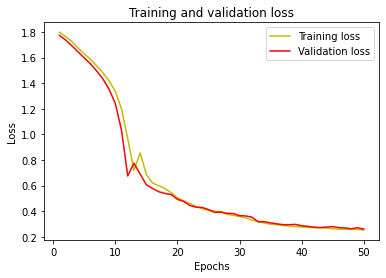

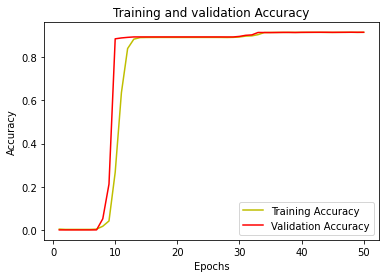

In [61]:
#plot the train and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [64]:
y_pred=model.predict(X_TEST)
y_pred_argmax=np.argmax(y_pred, axis=3)

from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(Y_TEST[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.33084393


In [67]:
#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])
class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[4,3]+ values[2,1]+ values[3,1])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)
print("IoU for class4 is: ", class5_IoU)

[[1.865994e+06 0.000000e+00 0.000000e+00 7.952000e+03 0.000000e+00
  0.000000e+00]
 [6.653100e+04 0.000000e+00 0.000000e+00 4.310000e+02 0.000000e+00
  0.000000e+00]
 [4.747100e+04 0.000000e+00 0.000000e+00 1.740000e+02 0.000000e+00
  0.000000e+00]
 [1.001600e+04 0.000000e+00 0.000000e+00 5.314800e+04 0.000000e+00
  0.000000e+00]
 [4.543500e+04 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00]
 [0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00]]
IoU for class1 is:  0.93394774
IoU for class2 is:  0.0
IoU for class3 is:  0.0
IoU for class4 is:  0.7410382
IoU for class4 is:  0.0


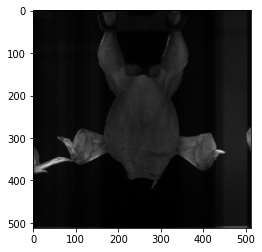

In [69]:
plt.imshow(train_imgs[0, :,:,0], cmap='gray')

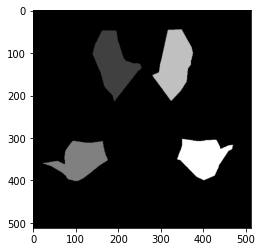

In [70]:
plt.imshow(mask_imgs[0], cmap='gray')

In [86]:
print(len(X_TEST))

8


In [87]:
import random
test_img_number = random.randint(0, len(X_TEST))
test_img = X_TEST[test_img_number]
ground_truth=Y_TEST[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

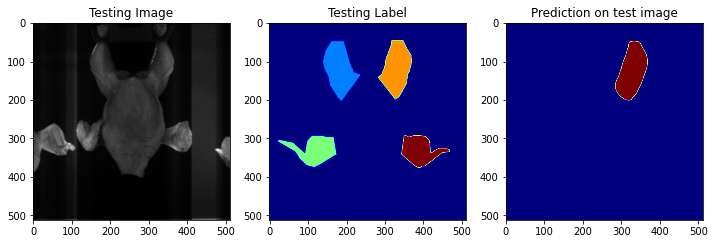

In [88]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [90]:
!pip install patchify 

0 0


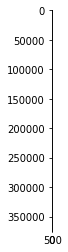

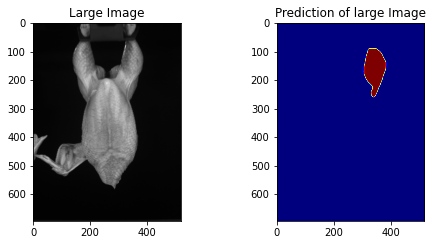

In [92]:
from patchify import patchify, unpatchify

large_image = cv2.imread('/content/drive/MyDrive/chicks/November-24-2020-09h38m53s11-Front_D.tif', 0)

patches = patchify(large_image, (512, 512), step=512)  #Step=256 for 256 patches means no overlap

predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        print(i,j)
        
        single_patch = patches[i,j,:,:]       
        single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1),2)
        single_patch_input=np.expand_dims(single_patch_norm, 0)
        single_patch_prediction = (model.predict(single_patch_input))
        single_patch_predicted_img=np.argmax(single_patch_prediction, axis=3)[0,:,:]

        predicted_patches.append(single_patch_predicted_img)

predicted_patches = np.array(predicted_patches)

predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 512,512) )

reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
plt.imshow(reconstructed_image, cmap='gray')
#plt.imsave('data/results/segm.jpg', reconstructed_image, cmap='gray')

plt.hist(reconstructed_image.flatten())  #Threshold everything above 0

# final_prediction = (reconstructed_image > 0.01).astype(np.uint8)
# plt.imshow(final_prediction)

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title('Large Image')
plt.imshow(large_image, cmap='gray')
plt.subplot(222)
plt.title('Prediction of large Image')
plt.imshow(reconstructed_image, cmap='jet')
plt.show()